In [1]:
# default_exp neural_networks

# neural_networks
> neural Networks. Duh.

In [2]:
#export 

import matplotlib.pyplot as plt
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#export

# from https://github.com/dennisbakhuis/Tutorials/blob/master/Neural_Network/Artificial_Neural_Network.ipynb
class ActivationDoesNotExist(Exception):
    """Valid activations are sigmoid, tanh, and relu, provided as a string"""
    pass

class InputDimensionNotCorrect(Exception):
    """Need to specify input dimension, i.e. input shape into the first layer"""
    pass

class LossFunctionNotDefined(Exception):
    """Loss function in cost() method not defined"""
    pass


class DenseLayer:
    """
    A class to define fully connected layers.
    """
    
    def __init__(self, inputDimension, units, activation='', randomMultiplier=0.01):
        """
        Constructor:
          inputDimension: number of input features
          units: number of neurons in the layer
          activation: activation function applied to layer
            - options: 'sigmoid', 'tanh', 'relu', ''
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.weights, self.bias = self.initialize(inputDimension, units, randomMultiplier)
        if activation == 'sigmoid':
            self.activation = activation
            self.activationForward = self.sigmoid
            self.activationBackward = self.sigmoidGrad
        elif activation == 'relu':
            self.activation = activation
            self.activationForward = self.relu
            self.activationBackward = self.reluGrad
        elif activation == 'tanh':
            self.activation = activation
            self.activationForward = self.tanh
            self.activationBackward = self.tanhGrad
        elif activation != '':
            raise ActivationDoesNotExist
        else:
            self.activation = 'none'
            self.activationForward = self.linear
            self.activationBackward = self.linear
    
    def initialize(self, nx, nh, randomMultiplier):
        """
        Initializes weights randomly:
          nx: number of input features
          nh: number of units
          randomMultiplier: multiplier applied to the random weights during initialization
        returns:
          weights: the randomly initialized weights
          bias: the bias terms
        """
        weights = randomMultiplier * np.random.randn(nh, nx)
        bias = np.zeros([nh, 1])
        return weights, bias

    
    def sigmoid(self, Z):
        """
        Sigmoid activation function
        """
        A = 1 / (1 + np.exp(-Z))
        return A
        
    def sigmoidGrad(self, dA):
        """
        Differential of sigmoid function with chain rule applied
        """
        s = 1 / (1 + np.exp(-self.prevZ))
        dZ = dA * s * (1 - s)
        return dZ
    
    
    def relu(self, Z):
        """
        Relu activation function
        """
        A = np.maximum(0, Z)
        return A
        
    def reluGrad(self, dA):
        """
        Differential of relu function with chain rule applied
        """
        s = np.maximum(0, self.prevZ)
        dZ = (s>0) * 1 * dA
        return dZ 

        
    def tanh(self, Z):
        """
        Tanh activation function
        """
        A = np.tanh(Z)
        return A

    def tanhGrad(self, dA):
        """
        Differential of tanh function with chain rule applied
        """
        s = np.tanh(self.prevZ)
        dZ = (1 - s**2) * dA
        return dZ


    def linear(self, Z):
        """
        Placeholder when no activation function is used
        """
        return Z
        
    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        return A
    
    
    def backward(self, dA):
        """
        Backward pass through layer
          dA: previous gradient
        """
        dZ = self.activationBackward(dA)
        m = self.prevA.shape[1]
        self.dW = 1 / m * np.dot(dZ, self.prevA.T)
        self.db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(self.weights.T, dZ)
        return prevdA
    
    
    def update(self, learning_rate):
        """
        Update weights using gradients from backward pass
          learning_rate: the learning rate used in the gradient descent
        """
        self.weights = self.weights - learning_rate * self.dW
        self.bias = self.bias - learning_rate * self.db

        
    def outputDimension(self):
        """
        Returns the output dimension for the next layer
        """
        return len(self.bias)

    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dense layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'


class NeuralNetwork:
    """
    Neural Network structure that holds our layers
    """
    
    def __init__(self, loss='cross-entropy', randomMultiplier = 0.01):
        """
        Constructor:
          loss: the loss function. Two are defined:
             - 'cross-entropy' and 'mean-square-error'
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.layers=[]
        self.randomMultiplier = randomMultiplier
        if loss=='cross-entropy':
            self.lossFunction = self.crossEntropyLoss
            self.lossBackward = self.crossEntropyLossGrad
        elif loss=='mean-square-error':
            self.lossFunction = self.meanSquareError
            self.lossBackward = self.meanSquareErrorGrad
        else:
            raise LossFunctionNotDefined
        self.loss=loss


    def addLayer(self, inputDimension=None, units=1, activation='', layer_type = DenseLayer):
        """
        Adds a Dense layer to the network:
          inputDimension: required when it is the first layer. otherwise takes dimensions of previous layer.
          units: number of neurons in the layer
          activation: activation function: valid choices are: 'sigmoid', 'tanh', 'relu', ''
        """
        if (inputDimension is None):
            if (len(self.layers)==0):
                raise InputDimensionNotCorrect
            inputDimension=self.layers[-1].outputDimension()
        layer = layer_type(inputDimension, units, activation, randomMultiplier= self.randomMultiplier)
        self.layers.append(layer)

    def crossEntropyLoss(self, Y, A, epsilon=1e-15):
        """
        Cross Entropy loss function
          Y: true labels
          A: final activation function (predicted labels)
          epsilon: small value to make minimize chance for log(0) error
        """
        m = Y.shape[1]
        loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
            
    def crossEntropyLossGrad(self, Y, A):
        """
        Cross Entropy loss Gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        return dA
    
    
    def meanSquareError(self, Y, A):
        """
        Mean square error loss function
          Y: true labels
          A: final activation function (predicted labels)
        """
        loss = np.square(Y - A)
        m = Y.shape[1]
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
    
    def meanSquareErrorGrad(self, Y, A):
        """
        Mean square error loss gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -2 * (Y - A)
        return dA

    
    def cost(self, Y, A):
        """
        Cost function wrapper
          Y: true labels
          A: final activation function (predicted labels)
        """
        return self.lossFunction(Y, A)

        
    def forward(self, X, attention=None):
        """
        Forward pass through the whole model.
          X: input vector
        """
        x = np.copy(X)
        for layer in self.layers:
            if 'Attention' in str(layer.__repr__):       
                x = layer.forward(x, attention)
                
            else:
                x = layer.forward(x)

        return x
            
    
    def backward(self, A, Y):
        """
        backward pass through the whole model
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = self.lossBackward(Y, A)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
    
    
    def update(self, learning_rate=0.01):
        """
        Update weights and do a step of gradient descent for the whole model.
          learning_rate: learning_rate to use
        """
        for layer in self.layers:
            layer.update(learning_rate)
    
    
    def __repr__(self):
        """
        Pretty print the model
        """
        layrepr = ['  ' + str(ix+1)+' -> ' + str(x) for ix, x in enumerate(self.layers)]
        return '[\n' + '\n'.join(layrepr) + '\n]'
   
    
    def numberOfParameters(self):
        """
        Print number of trainable parameters in the model
        """
        n = 0
        for layer in self.layers:
            n += np.size(layer.weights) + len(layer.bias)
        print(f'There are {n} trainable parameters in the model.')
        
        
        
        
        
  

In [4]:
num_features = 1
num_observations = 100

X = np.atleast_2d(np.linspace(-1,1,100)).T

y = np.atleast_2d((np.sin(X.squeeze()*3) + np.random.normal(0,.1,100))).T
X = X.reshape([num_features,num_observations])

y = y.reshape([1,num_observations])

X.shape, y.shape

((1, 100), (1, 100))

In [5]:

model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=1, units=10, activation='tanh')

model.addLayer(units=1, activation='')
model


num_iterations = 10000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, y)
    model.update()
    if ix % 1000 == 0:
        print('cost:', model.cost(y, A))

cost: 0.5309297586853127
cost: 0.1761364791668181
cost: 0.17087544870374596
cost: 0.16130979003955734
cost: 0.14669577682398868
cost: 0.12864663593996734
cost: 0.108666515502575
cost: 0.08642976866078214
cost: 0.06288016886481448
cost: 0.043270951776142416


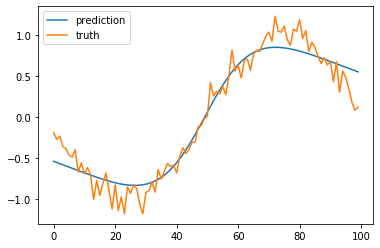

In [6]:
plt.plot(A.squeeze(),label='prediction')
plt.plot(y.squeeze(),label='truth')
plt.legend()

In [7]:
#export  

class DropoutLayer(DenseLayer):

    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)

        dropout_percent = 0.5
        
        
        A *= np.random.binomial([np.ones((A.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
    
    
    
class AttentionDropoutLayer(DenseLayer):

    
    def forward(self, A, attention):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
    
        dropout_percent = 0.5
        
        
        A *= attention

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Attention Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
   
    
class DropoutLayer(DenseLayer):

    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        dropout_percent = 0.5

        dropout_weights = self.weights * np.random.binomial([np.ones((self.weights.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        Z = np.dot(dropout_weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        
        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
    
    
class AttentionDropoutLayer(DenseLayer):

    
    def forward(self, A, attention):
        """
        Forward pass through layer
          A: input vector
        """
        
        attention_sparsity = np.mean(attention)
        weight_scaling = 1
        if attention_sparsity !=1:
            weight_scaling = (1.0/(1-attention_sparsity))
        
        attention_weights = self.weights* attention * weight_scaling
        Z = np.dot(attention_weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Attention Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'



In [8]:

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=1, units=10, activation='tanh')

model.addLayer( units=10, activation='tanh',layer_type = DropoutLayer)

model.addLayer( units=1, activation='',)
model

num_iterations = 10
num_iterations = 100000
for ix in range(num_iterations):
    # minibatch
    X_train, X_test, Y_train, y_test = train_test_split(X.T, y.T, test_size=0.7, random_state=42)
    X_train = X_train.T
    Y_train = Y_train.T

    A = model.forward(X_train)
    model.backward(A, Y_train)
    model.update()
    if ix % (num_iterations/10) == 0:
        print('cost:', model.cost(Y_train, A))

cost: 0.571461760089169
cost: 0.07329702730435064
cost: 0.06470697751108989
cost: 0.060077030162384915
cost: 0.09223437796892743
cost: 0.06486564011619365
cost: 0.07939384555642101
cost: 0.07074299564634644
cost: 0.06281283572215221
cost: 0.14862629704928715


ensemble prediction cost: 0.06110562016840012


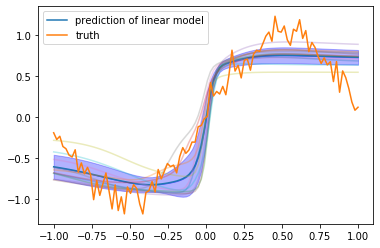

In [9]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]


pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

mean_prediction_cost = model.cost(y,pred_mean)

print(f'ensemble prediction cost: {mean_prediction_cost}')


plt.plot(X.squeeze(),pred_mean,label='prediction of linear model')
plt.fill_between(X.squeeze(), pred_mean, pred_mean - pred_std, alpha = 0.3,color='blue')
plt.fill_between(X.squeeze(), pred_mean, pred_mean + pred_std, alpha = 0.3,color='blue')

for sample in predictive_sample_list:
    plt.plot(X.squeeze(), sample,alpha=0.3)

plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

In [10]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_thompson_sampler.ipynb.
Converted 02_neural_networks.ipynb.
Converted index.ipynb.
